In [5]:
# importing functions for analysis
# I find I have to run this cell twice to get nice, large plots
from functions import *
from sim_functions import *

# sometimes just need to run with the below line uncommented
# plt.rcParams['figure.dpi'] = 200

# Simulations with PENTrack

In this notebook, simulation results from PENTrack are used in conjection with the experimental analysis in order to determine various material parameters.

## Questions

- what is an apporpriate number for simulated particles. Right now I'm achievuing only 10000 simulated particles (due to time-out issues) and less than 2000 are making it to the detector. Contrast that with experiment, where ~100000 are being detected in an equivalent run. 
- I should be able to just judge based on whatever error bar I get from each method, is the error on the fit parameter p1 correct? Is the built-in 'expo' function what you would use for this fit? If I can demonstrate a lack of agreement, or a lack of sensitivity to changes in drp, from just 10000 simulated particles, then we can move on right? 
- What do we move on to? If we're not able to budge this time constant by changing drp, then should I start changing imaginary fermi? This I would use to match just to pre-storage time, right? 
- Review my materials.in to make sure I'm setting things appropriately (where I 0'ed the other parameters in order to change drp)

## Direction
- Generate a function that takes as input the pre-storage time, and the configuration (to begin with, only TRIUMF-style), then it produces the drp1 and drp10 exponential fits (as shown below) using ROOT. For this it requires only the out.ROOT files, named strategically.
- Put the time constant analysis notebook in here, where it belongs.

# Diffuse Reflection Probability Analysis

We assume that the tail of the main detection peak is the most sensitive parameter to the diffuse reflection probability of the materials. 

## Experimental Data

The example below shows a fit of the experimental data

[[Model]]
    Model(expo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 3749
    # variables        = 2
    chi-square         = 823.800484
    reduced chi-square = 0.21985601
    Akaike info crit   = -5676.91986
    Bayesian info crit = -5664.46137
[[Variables]]
    p0:  18.4775627 +/- 0.01833680 (0.10%) (init = 80)
    p1: -0.04083699 +/- 6.6450e-05 (0.16%) (init = -0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.996



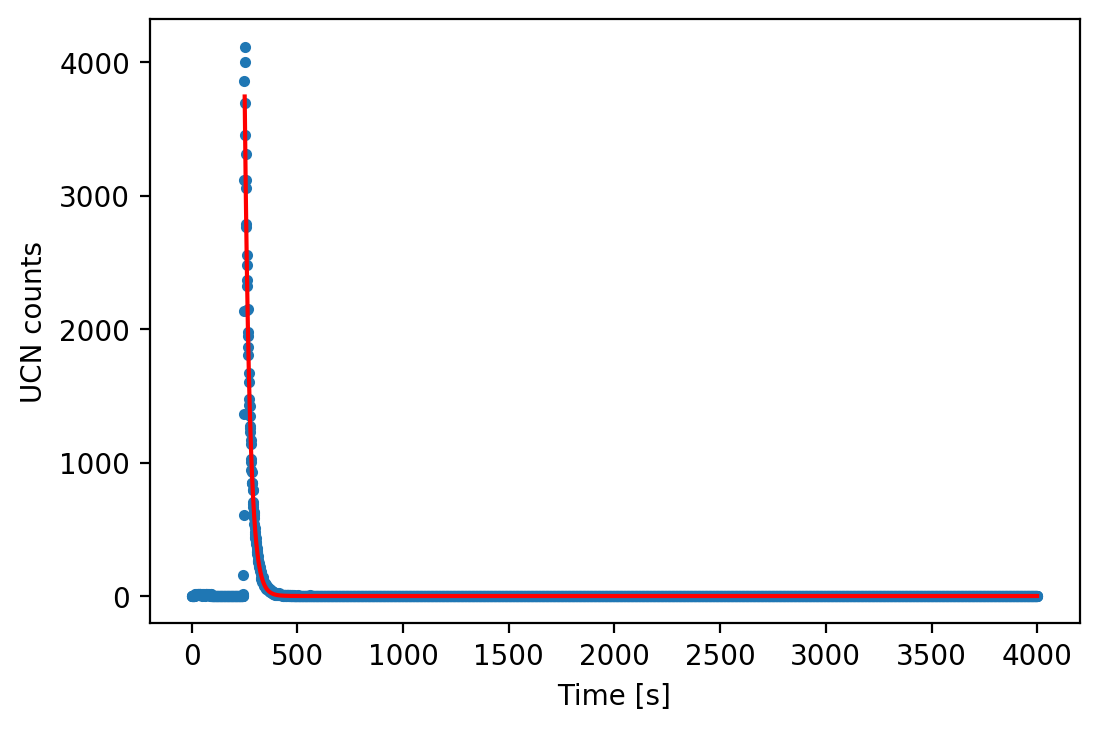

In [6]:
# load data from an example run 
arr = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));

# exponential function, same as ROOT's built-in 'expo'
def expo(x, p0, p1):
    return np.exp(p0 + p1 * x)

# We perform the fit on all of the data occurring after the peak count
# bin is observed
_counts = arr[:, 1]
max_index = _counts.argmax()
t = arr[max_index:-1, 0]
counts = _counts[max_index:-1]

# construct weights, we deal with entries = 0 by giving them 0 weight
weights = np.zeros(np.shape(counts))
for i in range(0,np.shape(counts)[0]):
    if (counts[i] != 0):
        weights[i] = 1 / np.sqrt(counts[i])
    else:
        weights[i] = 0
        
gmodel = Model(expo)
result = gmodel.fit(counts, x=t, p0=80, p1=-0.2, weights = weights)

print(result.fit_report())
plt.plot(arr[:,0], arr[:,1], '.')
plt.plot(t, result.best_fit, 'r-')
plt.ylabel('UCN counts')
plt.xlabel('Time [s]')
plt.savefig('../img/rough_tail_fit.pdf')
plt.show()

Next, this is performed iteratively on the data from each run in both the TRIUMF-style normalization confirguration, and the JP-style normalization configuration. 

(NOMI,s005): -0.038695+/-0.000014
(NOMI,s020): -0.036042+/-0.000014
(NOMI,s100): -0.031782+/-0.000025
(DISK,s005): -0.034968+/-0.000031
(DISK,s020): -0.032795+/-0.000032
(DISK,s100): -0.02980+/-0.00007


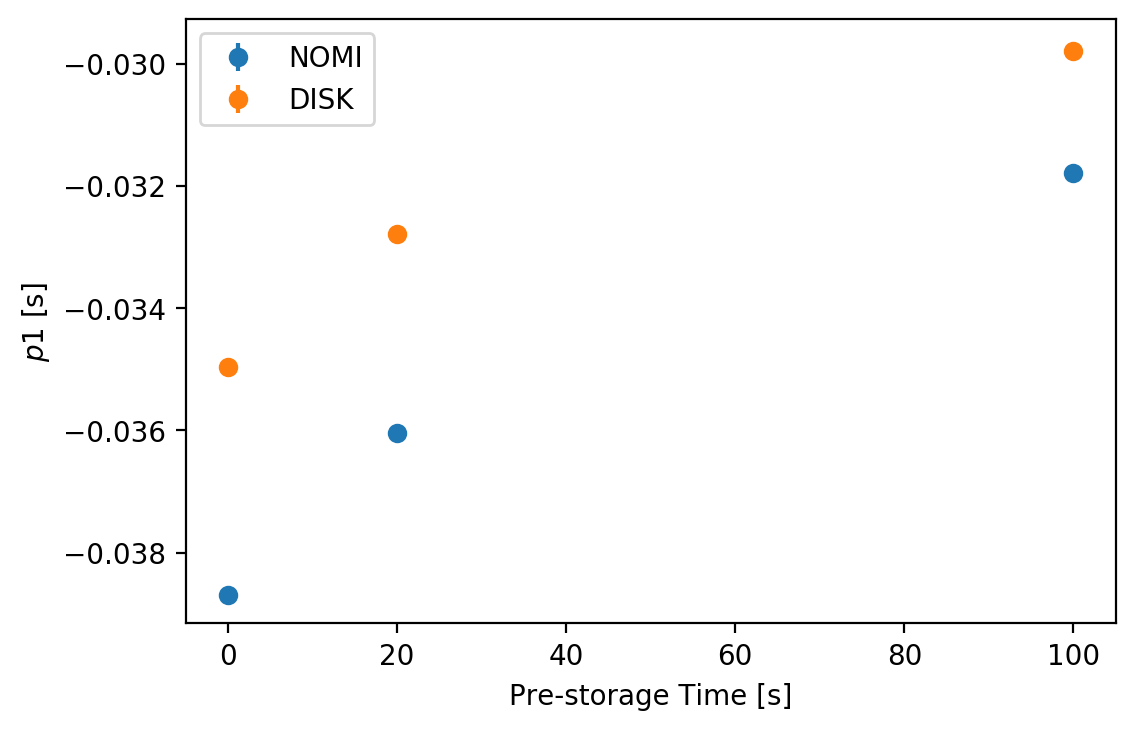

In [9]:
# dictionary to hold time constant values
tau_dict   = {} 

# dictionary to hold p1 values
exp_p1_dict = {}

fig, ax = plt.subplots()
ax_c = plt.gca()

for config in ['NOMI', 'DISK']:
    
    color = next(ax_c._get_lines.prop_cycler)['color']
    
    for run_type in ['s005', 's020', 's100']:
        
        # we'll save tau and error
        tau_dict[config, run_type] = np.empty((0,2), float)

        for filename in os.listdir('../data_ucn/main_detector_sorted'):

            # Only the files matching our desired configuration and run 
            # type are selected. The '.tof' condition is just so we 
            # don't perform the analysis twice per run (since it would
            # otherwise match to the .tof and the .txt files)
            if ((config in filename) and (run_type in filename) and 
            ('.tof' in filename)):

                # The data is retrieved from the .tof file
                arr = np.loadtxt('../data_ucn/main_detector_sorted/' + 
                                        filename[0:22] + '.tof',
                                        usecols = (0,1))
                
                # this if/else sequence handles cuts of the data, which for 
                # some runs is specific based on the experimental 
                # conditions
                # specific data cut for run 35 on the 8th
                if ((filename[2:3] == '8') and 
                    (filename[10:12] == '35')):
                    
                    _counts = arr[0:1000, 1]
                    t = arr[0:1000,0]

                # specific data cut for run 66 on the 8th
                elif ((filename[2:3] == '8') and 
                        (filename[10:12] == '66')):

                    _counts = arr[0:1500, 1]
                    t = arr[0:1500,0]

                # specific data cut for run 88 on the 8th
                elif ((filename[2:3] == '8') and 
                        (filename[10:12] == '88')):

                    _counts = arr[0:2500, 1]
                    t = arr[0:2500,0]
                    
                else:
                    _counts = arr[:, 1]
                    t = arr[:,0]
                
                max_index = _counts.argmax()
                t = t[max_index:-1]
                counts = _counts[max_index:-1]
                
#                 print('t shape = {}'.format(np.shape(t)))
#                 print('counts shape = {}'.format(np.shape(counts)))
#                 print(filename)
                # construct weights, we deal with entries = 0 by giving them 0 weight
                weights = np.zeros(np.shape(counts))
                for i in range(0,np.shape(counts)[0]):
                    if (counts[i] != 0):
                        weights[i] = 1 / np.sqrt(counts[i])
                    else:
                        weights[i] = 0
                
                gmodel = Model(expo)
                result = gmodel.fit(counts, x=t, p0=80, p1=-0.01, weights = weights)

#                 print(result.fit_report())
#                 plt.plot(t, counts, 'bo')
#                 plt.plot(t, result.best_fit, 'r-')
#                 plt.show()

                day_run_no = int(filename[1:3]) + (0.001
                                   * int(filename[9:12]))

                tau_dict[config, run_type] = np.append(
                    tau_dict[config, run_type], 
                    [[result.params['p1'].value, result.params['p1'].stderr]],
                    axis=0)
        
        # finished with given [config, run_type]
        # generate uncertainty array of data set, calculate mean, add to dict
        arr = tau_dict[config, run_type]
        uarr = unumpy.umatrix(arr[:,0], arr[:,1])
        ave_tau = uarr.mean(1)[0,0]
        
        exp_p1_dict[config, run_type] = ave_tau

        storage_time = int(run_type[1:-1])

        # add mean value to plot
        # JP-style
        if (config == 'DISK'):

            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)

        # TRIUMF-style
        else:
            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)
            
        print('(' + config + ',' + run_type + '): {}'.format(ave_tau))
                               
# presentation stuff
ax.set_ylabel(r'$p1$ [s]');
ax.set_xlabel('Pre-storage Time [s]')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());   
fig.savefig('../img/all_norm_tail_fits.pdf')

## Simulated Data

In the example below, simulation data produced with PENTrack are analysed in an analogous way to as seen above.

#####
NOMI, s005, dp = 10
#####

fitting range = [25.6, 80.6]

 FCN=287.56 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=5.44983e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.96246e+00   1.02093e-01   3.14029e-04   7.17442e-03
   2  Slope       -9.33930e-02   2.73698e-03   8.40987e-06   3.06634e-01
                               ERR DEF= 0.5


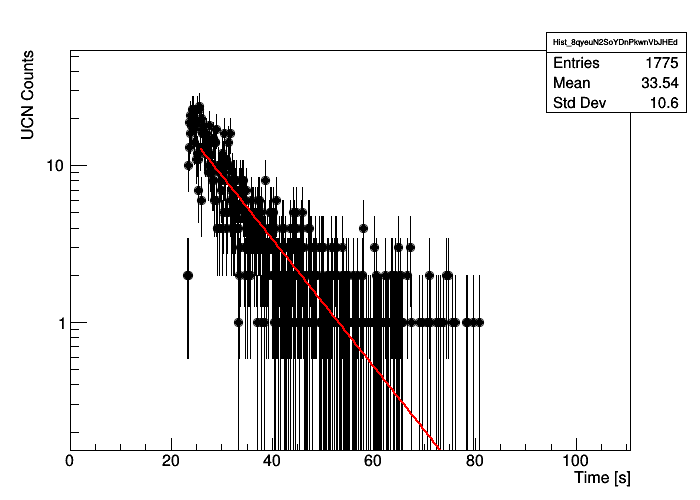

In [75]:
canvas, slope = sim_tau('NOMI', 's005', 10)

Next we perform this iteratively for different pre-storage times and diffuse reflection probabilities.

#####
NOMI, s005, dp = 10
#####

fitting range = [25.6, 80.6]

 FCN=287.56 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=5.44983e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.96246e+00   1.02093e-01   3.14029e-04   7.17442e-03
   2  Slope       -9.33930e-02   2.73698e-03   8.40987e-06   3.06634e-01
                               ERR DEF= 0.5


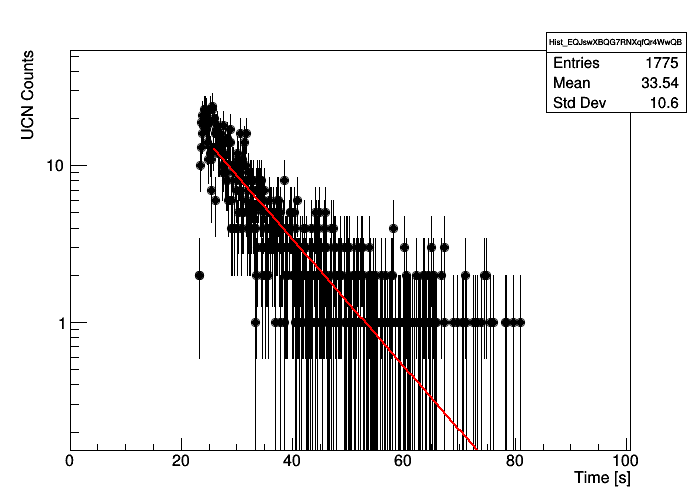

In [17]:
canvas_dict = {}
sim_p1_dict = {}

for config in ['NOMI']:
    
    for run_type in ['s005']:
#     for run_type in ['s005', 's020', 's100']:
        
        for diffuse_probability in [10]:
#         for diffuse_probability in [1, 10]:
            
            canvas, slope = sim_tau(config, run_type, diffuse_probability)
            
            canvas_dict[config, run_type, str(diffuse_probability)] = canvas
            
            sim_p1_dict[config,run_type,str(diffuse_probability)] = slope

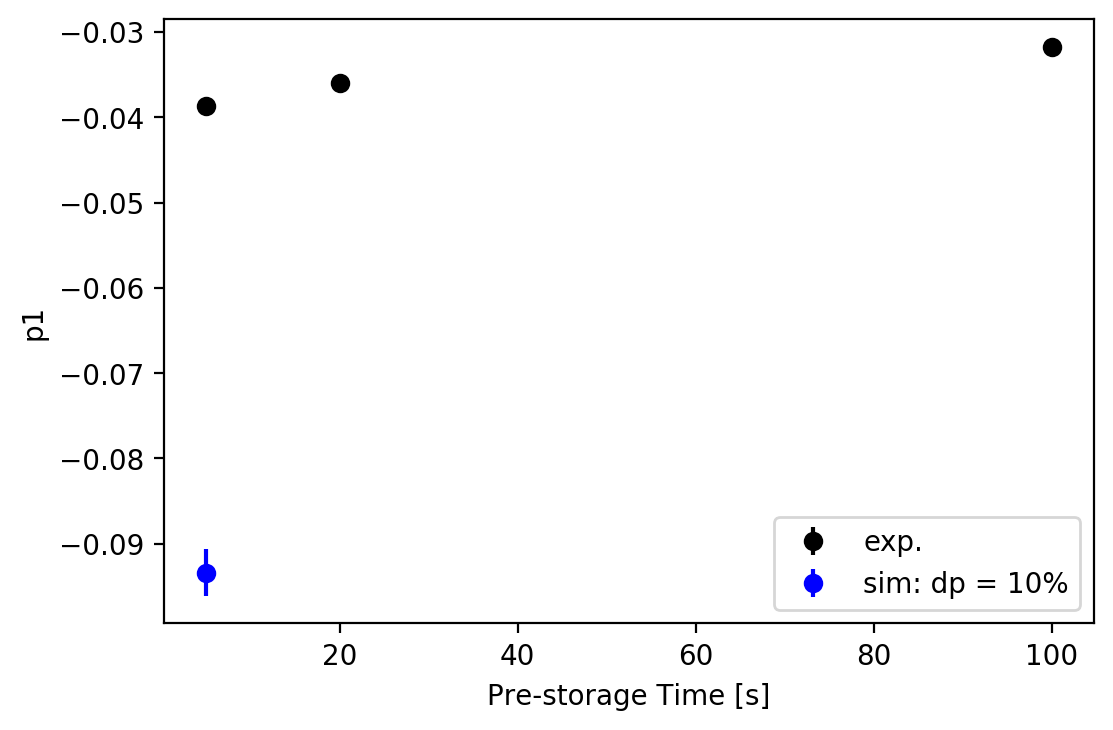

In [36]:
fig, ax = plt.subplots()
ax1 = plt.gca()

for config in ['NOMI']:
# for config in ['NOMI', 'DISK']:
    
#     for run_type in ['s005']:
    for run_type in ['s005', 's020', 's100']:
    
        exp_slope = exp_p1_dict[config, run_type]
        
        ax.errorbar(float(run_type[1:4]), exp_slope.nominal_value, yerr = exp_slope.std_dev,
                       label = 'exp.', fmt = 'o', color = 'k')
        
        for diffuse_probability in [1, 10]:
    
            if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 10):
            
                slope = sim_p1_dict[config, run_type, str(diffuse_probability)]
                
                color = next(ax1._get_lines.prop_cycler)['color']
                
                ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
                           label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = 'b')
                
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 1):
            
#                 slope = sim_p1_dict[config, run_type, str(diffuse_probability)]
                
#                 color = next(ax1._get_lines.prop_cycler)['color']
                
#                 ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
#                            label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
    
    
ax.set_ylabel('p1')
ax.set_xlabel('Pre-storage Time [s]')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());

## Scratch

- make an iterative function that does all the simulation data at once
- put all the experimental analysis in here
- make a function that takes both data sets and produces publication ready plots for comparison, with full error analysis

In [35]:
str(1).zfill(2)

'01'

#####
NOMI, s005, dp = 10
#####

 FCN=295.616 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=1.05908e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.00294e+00   9.76064e-02   3.08049e-04  -3.12820e-05
   2  Slope       -9.42574e-02   2.66496e-03   8.41061e-06  -1.34233e-03
                               ERR DEF= 0.5


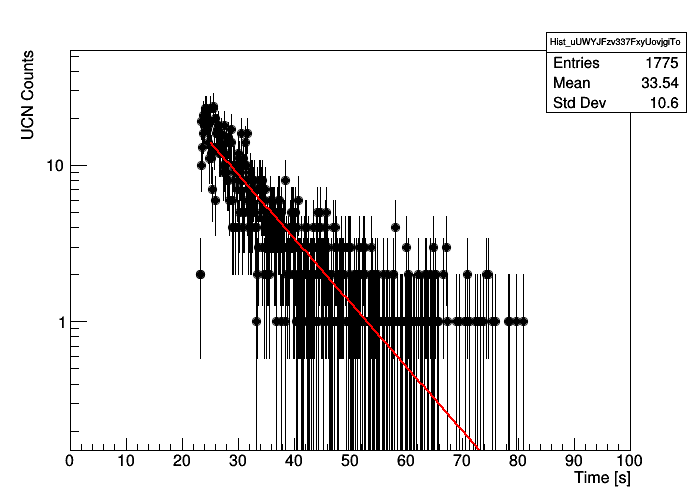

In [52]:
f = root_open('../data_sim/' + 'NOMI' + '_' + 's005' + 
              '_dp' + str(diffuse_probability).zfill(2) + '.root')

# print data information
print('#####')
print(config + ', ' + run_type + ', dp = {}'.format(diffuse_probability))
print('#####\n')
# get the neutronend tree
end = f.Get('neutronend')

# using rootpy to define the histogram
h1 = Hist(4000, 0, 400)

# a canvas for plotting
canvas = Canvas(width=700, height=500)

# fill a histogram with only the neutrons ending in the detector
for evt in f.neutronend:
   if evt.solidend == 200: h1.Fill(evt.tend)

# set the axis ranges for viewability
#     h1.GetYaxis().SetRangeUser(0, 50)
h1.GetXaxis().SetRangeUser(0, 100)

# logarithmic y scale 
canvas.SetLogy()

# draw histogram to the canvas
h1.Draw("hist")
canvas.Draw()

# fitting
f1 = ROOT.TF1("m1","expo",25,80)
f1.SetParameters(7,-0.2)
fit = h1.Fit(f1, 'SRL')

# get the slope, or inverse tau, parameter
slope = 1

h1.GetXaxis().SetTitle('Time [s]')
h1.GetYaxis().SetTitle('UCN Counts')
h1.Draw()

In [67]:
print(f1.GetParameter(1))
print(f1.GetParError(1))

-0.09425743849006823
0.0026649604693394207
